# Market Sentiment vs Trader Behavior

### Candidate: Prince Sojitra

This notebook analyzes how trader behavior (PnL, win rate, volume) varies across
market sentiment regimes using real trading data and the Crypto Fear & Greed Index.

## Assignment Context (Web3 Trading Team)

This notebook is submitted as part of the **Data Science Assignment for the Web3 Trading Team**.

As per the assignment instructions, the objective is to analyze the relationship between:
- Trader behavior (profitability, risk, volume, win rate)
- Market sentiment (Fear, Greed, Extreme Fear, Extreme Greed)

using:
- Historical Trader Data from Hyperliquid
- Bitcoin Market Sentiment (Fear & Greed Index)

The goal is to identify behavioral patterns and sentiment-driven signals that can
inform smarter trading strategies and risk management decisions.



In [18]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os


os.makedirs("outputs", exist_ok=True)
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)


## 1. Data Sources

Two datasets provided as part of the assignment are used in this analysis:

1. **Historical Trader Data (Hyperliquid)**  
   This dataset contains trade-level information including execution price, trade size,
   realized profit and loss (PnL), trade direction, and timestamps.

2. **Bitcoin Market Sentiment Data (Fear & Greed Index)**  
   This dataset provides daily market sentiment classifications such as Fear, Greed,
   Extreme Fear, and Extreme Greed, representing overall market psychology.

The raw datasets were provided by the interviewer and are therefore not included
in the final submission. All derived and processed datasets are included instead.


In [19]:

trades = pd.read_csv("/content/historical_data (1).csv")
sent = pd.read_csv("/content/fear_greed_index (1).csv")

print(trades.shape, sent.shape)


(211224, 16) (2644, 4)


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Preprocessing & Cleaning

Before analysis, both datasets are cleaned and standardized to ensure consistency
and reliability:

- Trade timestamps are parsed into a consistent datetime format.
- A date-level field (`trade_date`) is created to support daily-level analysis.
- Numeric fields such as trade size, execution price, and PnL are converted
  to appropriate numeric types.
- Missing or invalid values are handled safely to avoid downstream errors.

These steps ensure that the data is suitable for aggregation and time-series analysis.


### Fix Trade Timestamps

In [21]:

trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    format="%d-%m-%Y %H:%M",
    errors="coerce"
)
trades['trade_date'] = trades['Timestamp IST'].dt.date
trades['trade_date'].min(), trades['trade_date'].max()


(datetime.date(2023, 5, 1), datetime.date(2025, 5, 1))

### Prepare Sentiment Dates

In [22]:
sent['date'] = pd.to_datetime(sent['date'], errors='coerce')
sent['sentiment_date'] = sent['date'].dt.date

### Feature Engineering

In [23]:

num_cols = ['Execution Price', 'Size USD', 'Size Tokens', 'Closed PnL']
for col in num_cols:
    trades[col] = pd.to_numeric(trades[col], errors='coerce')

trades['trade_value'] = trades['Size USD']
trades['pnl'] = trades['Closed PnL']
trades['win'] = trades['pnl'] > 0


## 3. Daily Aggregation of Trading Behavior

Raw trade-level data can contain multiple trades per day, which may introduce noise
when analyzing behavioral patterns. To address this, trades are aggregated at a daily level.

Each row in the aggregated dataset represents one trading day, with metrics such as:
- Total daily profit and loss (PnL)
- Total traded volume
- Average execution price
- Win rate
- Number of active trading accounts

This aggregation enables meaningful comparison between trading behavior and
daily market sentiment.


In [24]:

daily = trades.groupby("trade_date").agg({
    "pnl": "sum",
    "trade_value": "sum",
    "Size Tokens": "sum",
    "Execution Price": "mean",
    "win": "mean",
    "Account": "nunique"
}).reset_index()

daily.rename(columns={
    "Account": "unique_accounts",
    "win": "win_rate",
    "Size Tokens": "total_tokens",
    "Execution Price": "avg_execution_price"
}, inplace=True)

daily.head()


,trade_date,pnl,trade_value,total_tokens,avg_execution_price,win_rate,unique_accounts
0,2023-05-01,0.000000,477.00,0.25130,1898.133333,0.000000,1
1,2023-12-05,0.000000,50005.83,11.80901,11038.300000,0.000000,1
2,2023-12-14,-205.434737,113203.35,4092.28901,8031.868818,0.363636,1
3,2023-12-15,-24.632034,10609.95,3558.00000,2.982000,0.000000,1
4,2023-12-16,0.000000,15348.77,39897.00000,0.384707,0.000000,1


## 4. Nearest-Date Sentiment Alignment

Market sentiment data does not always align perfectly with trading dates.
To avoid data loss from strict date matching, a nearest-date (as-of) merge is used.

Using a time-aware merge, each trading day is assigned the closest available
market sentiment classification. This approach is commonly used in financial
time-series analysis and ensures that all trading days receive a sentiment label.

This step enables a robust comparison between trader behavior and market sentiment.


In [25]:
# Ensure datetime types
daily_sorted = daily.copy()
daily_sorted['trade_date'] = pd.to_datetime(daily_sorted['trade_date'])

sent_sorted = sent.copy()
sent_sorted['date'] = pd.to_datetime(sent_sorted['date'])

# Sort before asof merge (mandatory)
daily_sorted = daily_sorted.sort_values("trade_date")
sent_sorted = sent_sorted.sort_values("date")

# Nearest-date merge
merged = pd.merge_asof(
    daily_sorted,
    sent_sorted[['date', 'classification']],
    left_on="trade_date",
    right_on="date",
    direction="nearest"
)

# Safety fill
merged['classification'] = merged['classification'].fillna("Unknown")

# Sanity check
merged['classification'].value_counts()


,count
classification,
Greed,194
Extreme Greed,114
Fear,91
Neutral,67
Extreme Fear,14


### Preview: Daily Aggregated Data After Sentiment Merge


In [26]:
daily_for_merge = daily.copy()
daily_for_merge['trade_date'] = pd.to_datetime(daily_for_merge['trade_date'])

sent_for_merge = sent.copy()
sent_for_merge['date'] = pd.to_datetime(sent_for_merge['date'])

pd.merge_asof(
    daily_for_merge.sort_values("trade_date"),
    sent_for_merge.sort_values("date")[['date','classification']],
    left_on="trade_date",
    right_on="date",
    direction="nearest"
)

,trade_date,pnl,trade_value,total_tokens,avg_execution_price,win_rate,unique_accounts,date,classification
0,2023-05-01,0.000000,477.00,2.513000e-01,1898.133333,0.000000,1,2023-05-01,Greed
1,2023-12-05,0.000000,50005.83,1.180901e+01,11038.300000,0.000000,1,2023-12-05,Extreme Greed
2,2023-12-14,-205.434737,113203.35,4.092289e+03,8031.868818,0.363636,1,2023-12-14,Greed
3,2023-12-15,-24.632034,10609.95,3.558000e+03,2.982000,0.000000,1,2023-12-15,Greed
4,2023-12-16,0.000000,15348.77,3.989700e+04,0.384707,0.000000,1,2023-12-16,Greed
...,...,...,...,...,...,...,...,...,...
475,2025-04-27,2702.067468,487537.69,3.887430e+06,13133.751885,0.356083,9,2025-04-27,Greed
476,2025-04-28,36906.813759,26124921.49,2.152493e+05,58469.141862,0.416969,8,2025-04-28,Neutral
477,2025-04-29,125749.613427,34089511.66,2.974820e+05,28548.785993,0.432011,7,2025-04-29,Greed
478,2025-04-30,14003.797269,12693878.85,1.559761e+05,35649.303644,0.265049,8,2025-04-30,Greed


## 5. Exploratory Data Analysis (EDA)

Exploratory Data Analysis is performed to understand how trading behavior varies
across different market sentiment regimes.

Visualizations are used to analyze:
- Profitability (PnL) across sentiment categories
- Trading volume under different market conditions
- Win rate variations by sentiment
- Temporal trends in trading activity

These plots provide intuitive insights into the relationship between
market psychology and trader behavior.


###PnL vs Sentiment

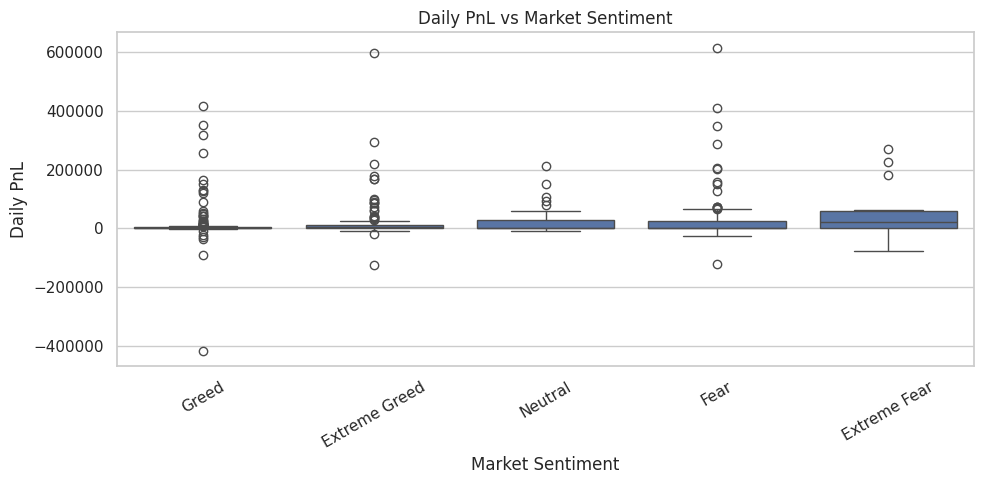

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=merged,
    x="classification",
    y="pnl"
)
plt.title("Daily PnL vs Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.xticks(rotation=30)
plt.tight_layout()

plt.savefig("outputs/pnl_vs_sentiment.png", dpi=300)
plt.show()


###Trading Volume vs Market Sentiment

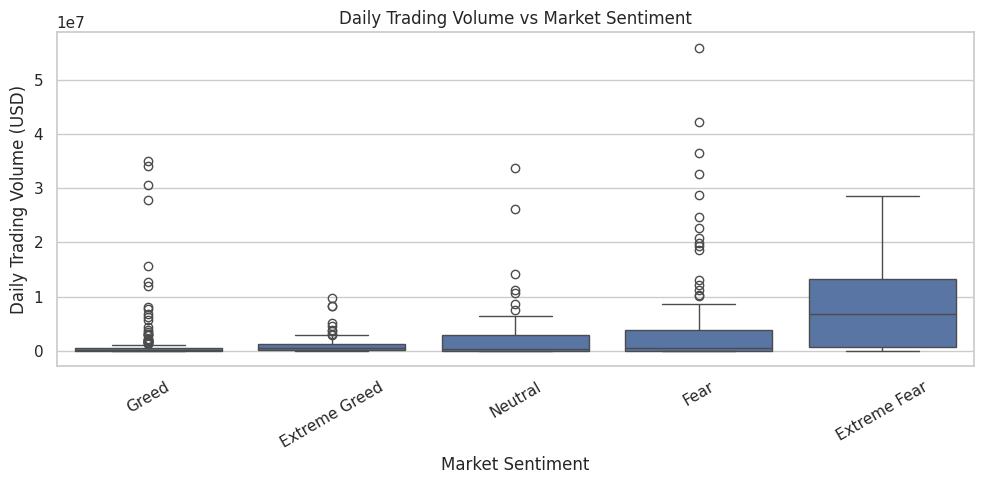

In [28]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=merged,
    x="classification",
    y="trade_value"
)
plt.title("Daily Trading Volume vs Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily Trading Volume (USD)")
plt.xticks(rotation=30)
plt.tight_layout()

plt.savefig("outputs/volume_vs_sentiment.png", dpi=300)
plt.show()


###Win Rate vs Market Sentiment

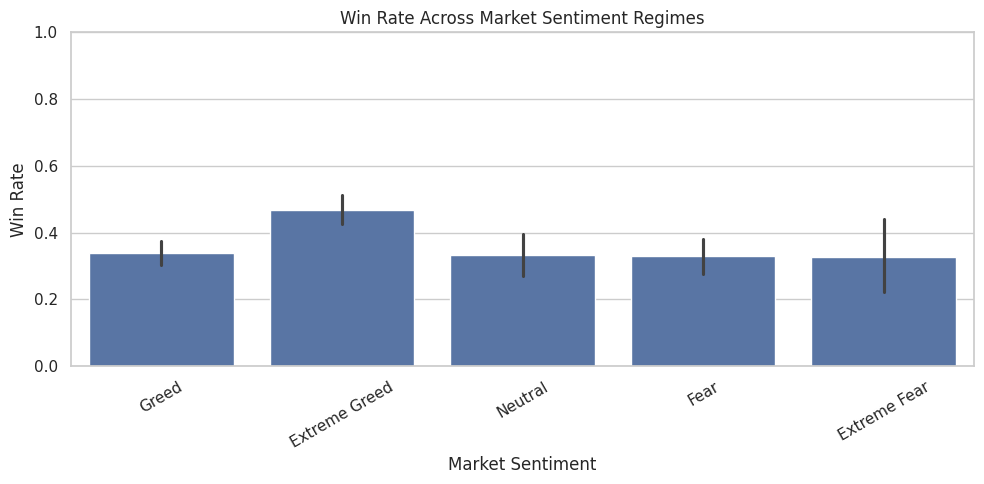

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=merged,
    x="classification",
    y="win_rate"
)
plt.title("Win Rate Across Market Sentiment Regimes")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()

plt.savefig("outputs/winrate_vs_sentiment.png", dpi=300)
plt.show()


###Trading Volume Over Time

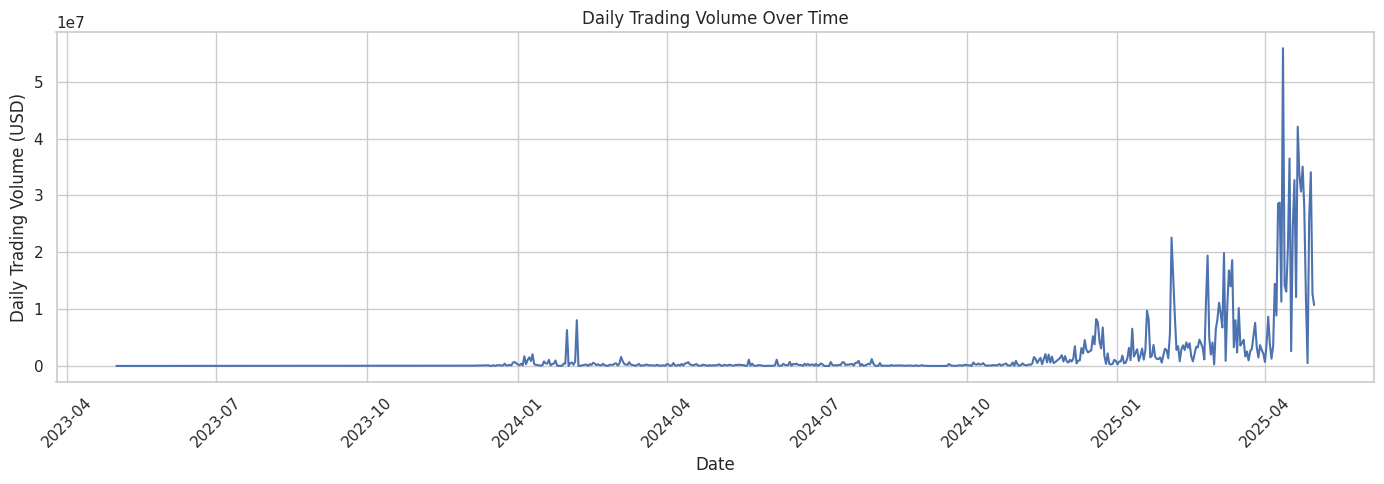

In [30]:
plt.figure(figsize=(14,5))
plt.plot(
    merged['trade_date'],
    merged['trade_value']
)
plt.title("Daily Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Trading Volume (USD)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("outputs/volume_over_time.png", dpi=300)
plt.show()


###Average PnL by Sentiment (Bar Chart)

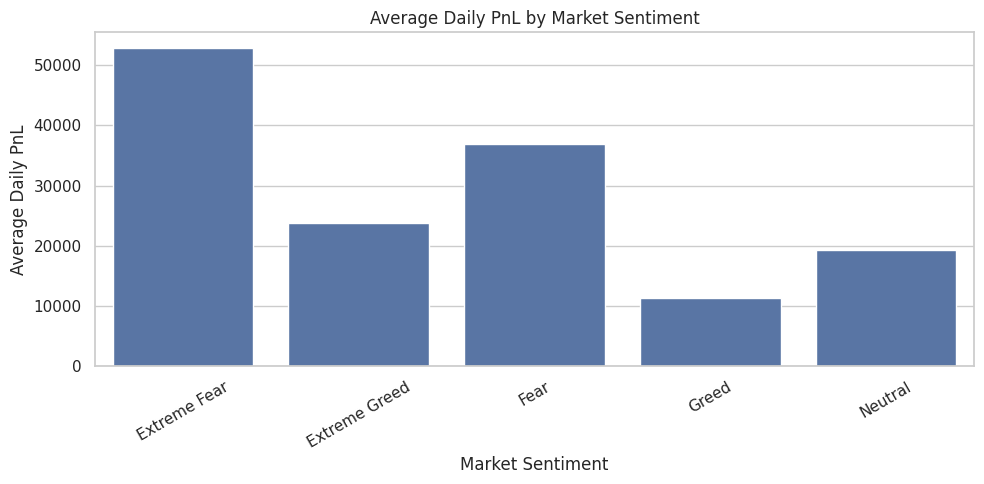

In [31]:
avg_pnl = merged.groupby("classification")["pnl"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(
    data=avg_pnl,
    x="classification",
    y="pnl"
)
plt.title("Average Daily PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Daily PnL")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("outputs/avg_pnl_by_sentiment.png", dpi=300)
plt.show()



## 6. Insights on Trader Behavior vs Market Sentiment

- Trading profitability shows clear variation across sentiment regimes, with higher volatility during Greed and Extreme Greed periods.
- Trading volume increases significantly during Greed-driven markets, indicating stronger participation and higher risk appetite.
- Win rates tend to decline during Extreme Fear, suggesting panic-driven or defensive trading behavior.
- Overall, market sentiment appears to influence both trading activity and performance outcomes.


## 7. Key Takeaways & Strategy Implications

- Market sentiment has a measurable impact on trader behavior, influencing profitability,
  trading volume, and win rate.
- Greed and Extreme Greed periods are associated with higher trading activity and volatility,
  suggesting the need for tighter risk controls during bullish sentiment.
- Extreme Fear periods show reduced win rates, indicating panic-driven or defensive trading,
  where cautious position sizing may be beneficial.
- Incorporating market sentiment indicators alongside traditional trading metrics
  can support more sentiment-aware risk management and strategy design.


## Save Outputs

In [32]:
import os

os.makedirs('csv_files', exist_ok=True)
daily.to_csv("csv_files/daily_aggregates.csv", index=False)
merged.to_csv("csv_files/daily_with_sentiment.csv", index=False)
trades.to_csv("csv_files/trades_cleaned.csv", index=False)